In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# utility imports
from utilities.processing_utility import get_q_2_cw_data 

# strategies imports
from strategies.gp_mean_reversion import *

In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


In [3]:
# get train test split
split_idx = int(len(df) * 0.7)
excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

r_train, r_test = get_train_test_split(series = excess_return_data, split_index = split_idx)
p_train, p_test = get_train_test_split(series = price_data, split_index = split_idx)
x_train, x_test = get_train_test_split(series = x_data, split_index = split_idx)

Text(0.5, 1.0, 'S&P 500 normalised Excess Returns')

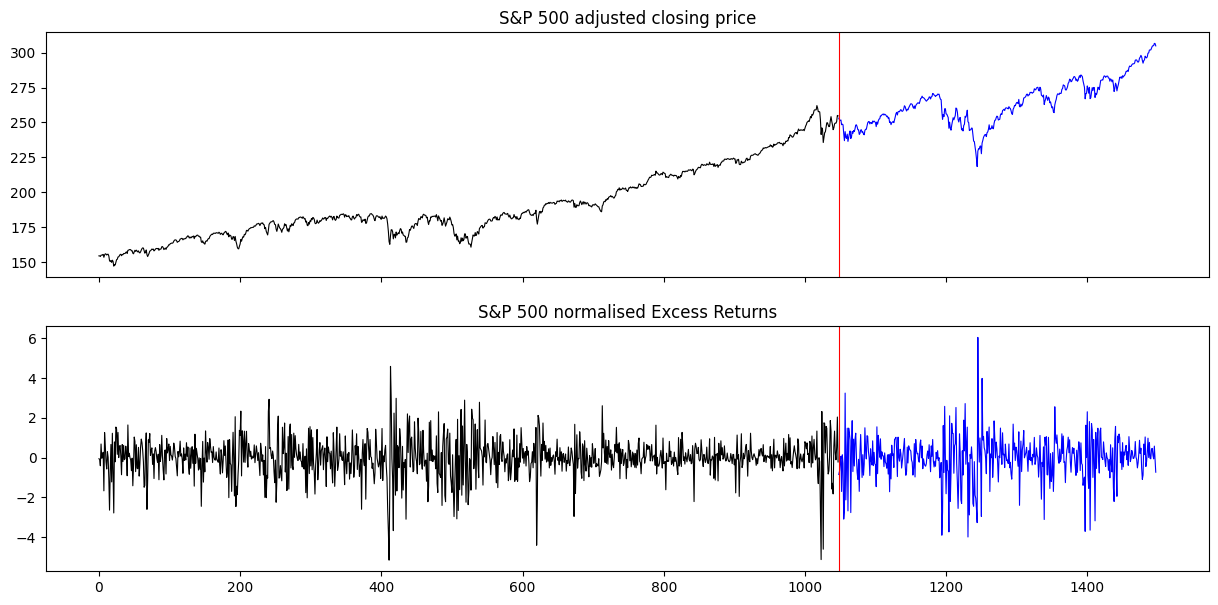

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 7))

# plot the original price series
ax1.plot(x_train, p_train, color = 'black', lw = 0.8, alpha = 1)
ax1.plot(x_test, p_test, color = 'blue', lw = 0.8, alpha = 1)
ax1.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax1.set_title('S&P 500 adjusted closing price')

# plot the normalised excess returns
ax2.plot(x_train, r_train, color = 'black', lw = 0.8, alpha = 1)
ax2.plot(x_test, r_test, color = 'blue', lw = 0.8, alpha = 1)
ax2.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax2.set_title('S&P 500 normalised Excess Returns')

# Method 1: Using the _evidence_

In [6]:
lengthscale_hat, noise_hat = optimise_marginal_likelihood(
                                inputs=x_train,
                                targets=r_train)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
           10           |   1.4031802415847778   |        0.64969         |        0.64940         
----------------------------------------------------------------------------------------------------
           20           |   1.389398455619812    |        0.60387         |        0.60387         
----------------------------------------------------------------------------------------------------
           30           |   1.383241891860962    |        0.56093         |        0.56354         
----------------------------------------------------------------------------------------------------
           40           |   1.3751327991485596   |        0.52424         |        0.52801         
----------------------------------------------------------------------------------------------------
           50           |   1.3712743520736694   |        0.49228         |        0.49916      

In [7]:
# train set predictions
train_returns, train_w, train_cash, train_long_idx, train_short_idx, train_gp_posterior = gaussian_process_mean_reversion_strategy(
                                                                                            price_series = p_train, 
                                                                                            daily_excess_returns_series = r_train,
                                                                                            x_series = x_train,
                                                                                            length_scale = lengthscale_hat,
                                                                                            noise = noise_hat,)

1047it [00:41, 25.47it/s]


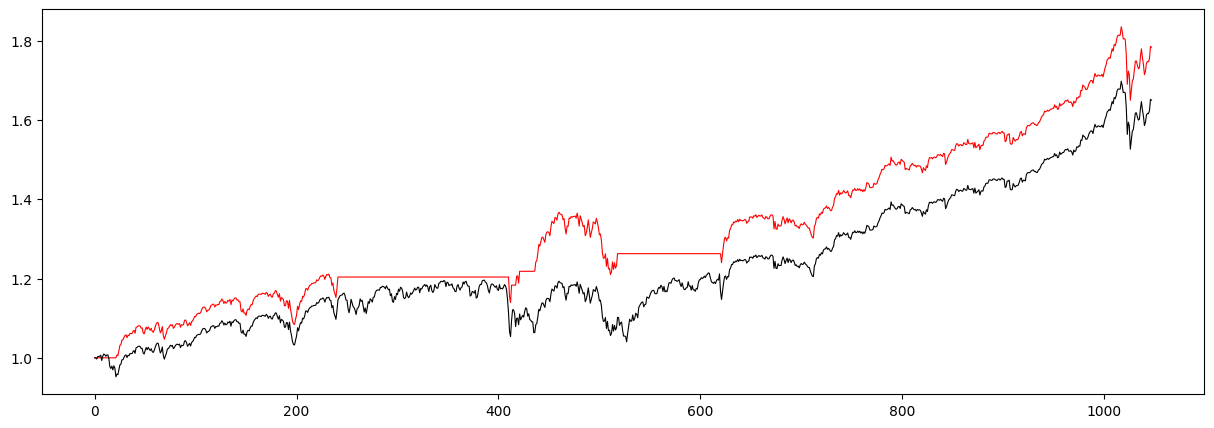

In [8]:
plt.plot(train_returns, color = 'red', lw = 0.8, alpha = 1)
plt.plot(p_train/p_train[0], color = 'black', lw = 0.8, alpha = 1)

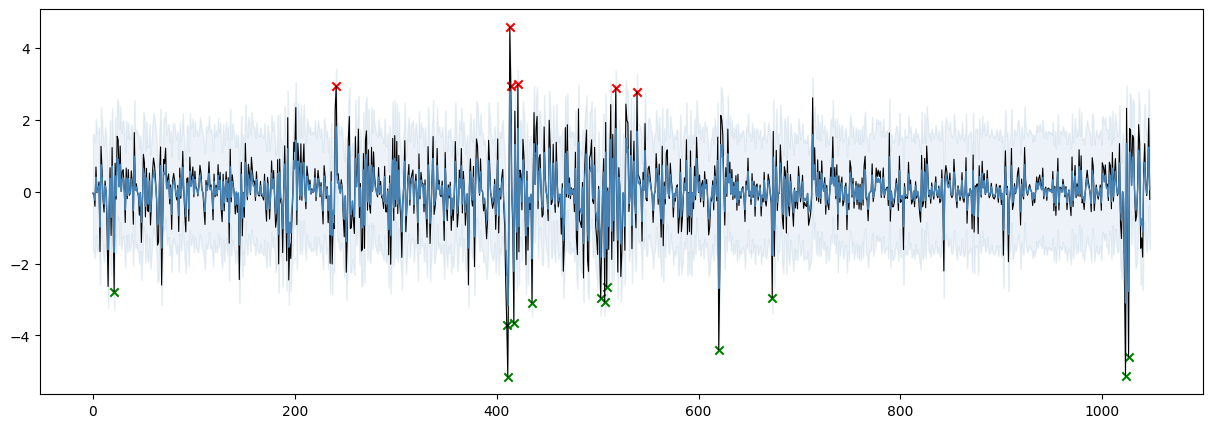

In [9]:
fig, ax = plt.subplots(1, 1)

plot_strategy(ax, r_train, x_train, train_gp_posterior, train_long_idx,train_short_idx)

In [12]:
# test set predictions
test_returns, test_w, test_cash, test_long_idx, test_short_idx, test_gp_posterior = gaussian_process_mean_reversion_strategy(
                                                                                    price_series = p_test,
                                                                                    daily_excess_returns_series = r_test,
                                                                                    x_series = x_test,
                                                                                    length_scale = lengthscale_hat,
                                                                                    noise = noise_hat)

449it [00:03, 115.47it/s]


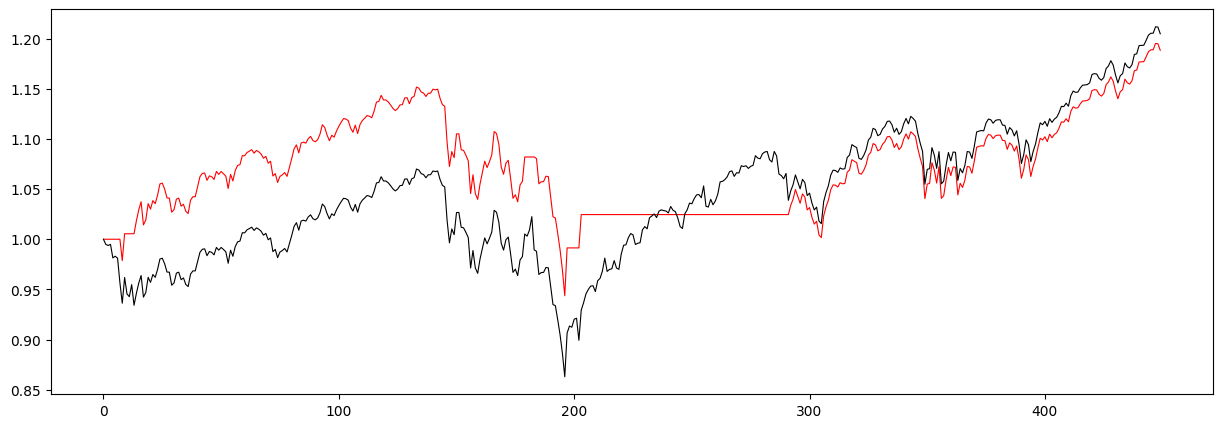

In [13]:
plt.plot(test_returns, color = 'red', lw = 0.8, alpha = 1)
plt.plot(p_test/p_test[0], color = 'black', lw = 0.8, alpha = 1)

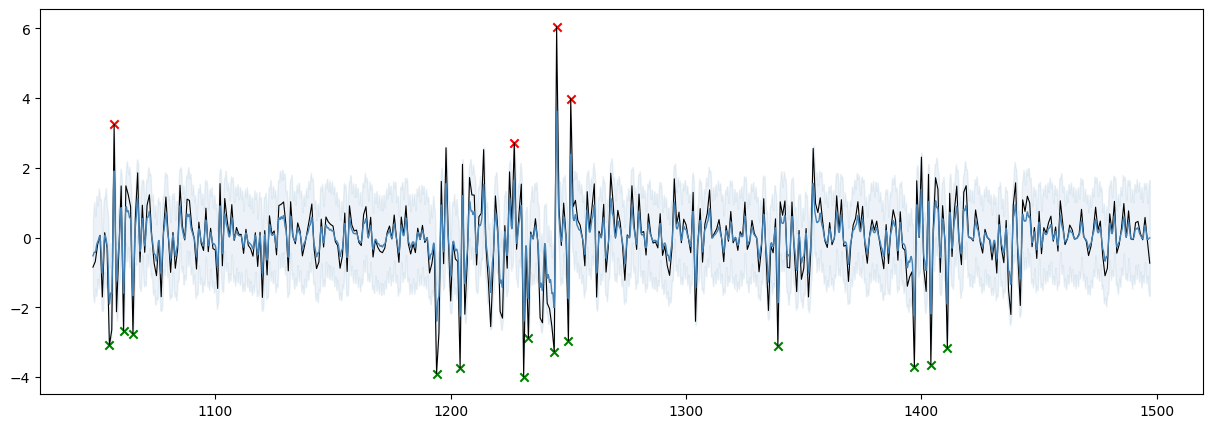

In [14]:
fig, ax = plt.subplots(1, 1)

plot_strategy(ax, r_test, x_test, test_gp_posterior, test_long_idx, test_short_idx)